In [1]:
%matplotlib inline
import os
import requests
import urllib 

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from scipy import stats as sps
from sklearn.feature_selection import SelectFromModel
from IPython.display import display
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import halfnorm
import random
import math

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
covid_cases = pd.read_csv('/Users/likehang/Desktop/Thesis/data/covid_19_t.csv', parse_dates =["day"])
icu = pd.read_csv('/Users/likehang/Desktop/Thesis/data/icu_bed.csv')

In [4]:
covid_cases

,day,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,210,110361,4371,194920,53487,638140,53612,51255,16593,13325,...,135770,568812,47157,1530,796,108282,68263,8738,66196,3360
210,211,111478,4438,195557,54216,647274,53882,51314,16643,13354,...,137800,574633,47521,1533,828,109019,68689,8807,67493,3431
211,212,112449,4520,196280,54765,652267,54211,51432,16718,13409,...,139175,579892,47982,1537,869,109879,69389,8987,68233,3457
212,213,113632,4588,196899,55652,658900,54211,51519,16770,13469,...,140844,585632,48445,1541,932,110857,69779,9077,69059,3524


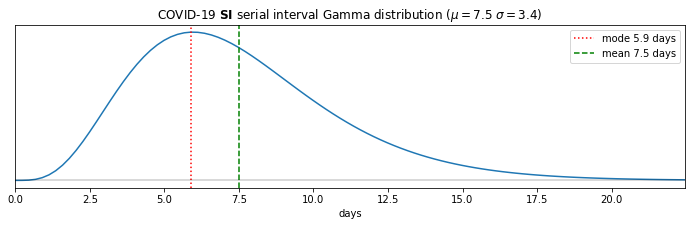

In [14]:
SI_mu = 7.5
SI_sd = 3.4

# The shape parameter alpha = SI_mu**2 / SI_sd**2 and scale parameter beta = SI_sd**2 / SI_mu
shape = SI_mu**2 / SI_sd**2 
scale = SI_sd**2 / SI_mu
SI_dist = sps.gamma(a=shape, scale=scale)
SI_x = np.linspace(SI_dist.ppf(0), SI_dist.ppf(.999), 100)
SI_y = SI_dist.pdf(SI_x)

omega = SI_x[SI_y.argmax()]
mean = SI_dist.stats(moments="m")

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(SI_x, SI_y)
ax.axvline(omega, c="r", ls=":", label=f"mode {omega:.1f} days")
ax.axvline(mean, c="g", ls="--", label=f"mean {mean:.1f} days")

ax.legend()
ax.axhline(0, c="k", alpha=.2)
ax.set_xlim(0, SI_x.max())
ax.set_yticks([])
ax.set_xlabel("days")
ax.set_title(fr"COVID-19 $\mathbf{{SI}}$ serial interval Gamma distribution ($\mu={SI_mu}$ $\sigma={SI_sd}$)")
plt.show();

In [3]:
# Smooth the time series
Alabama_y = covid_cases['Alabama'].rolling(7, win_type='gaussian',min_periods=1,center=True).mean(std=2).round().values
Alabama_y[Alabama_y<0] = 0

In [28]:
covid_cases

,day,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming,lag
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
4,5,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,210,110361,4371,194920,53487,638140,53612,51255,16593,13325,...,568812,47157,1530,796,108282,68263,8738,66196,3360,109004.0
210,211,111478,4438,195557,54216,647274,53882,51314,16643,13354,...,574633,47521,1533,828,109019,68689,8807,67493,3431,110361.0
211,212,112449,4520,196280,54765,652267,54211,51432,16718,13409,...,579892,47982,1537,869,109879,69389,8987,68233,3457,111478.0
212,213,113632,4588,196899,55652,658900,54211,51519,16770,13469,...,585632,48445,1541,932,110857,69779,9077,69059,3524,112449.0


For each day $t=[0,T]$ (where $T$ is the last observed day), smoothed new cases $y_{t}$ will be supposed distributed as Poisson with $\lambda_{t}$ parameter

$$
y_{t} \sim \mathcal{P}(\lambda_{t})
$$

where $\lambda_{t}$ is defined by the inverse serial interval $\gamma$, previous day smoothed new cases $k_{t-1}$ and effective reproduction number in time $R_{t}$ (ref: Bettencourt & Ribeiro 2008)

$$
\lambda_{t} = k_{t-1} e^{\gamma (R_{t} - 1)}
$$

In [ ]:
y[t] = possion(lambda[t])
lambda[t] = K[t] * exp( gamma * (R[t] - 1) )

For parameter $\gamma$, it is the inverse serial interval SI, which is supposed to be distributed as **Gamma**, with mean $\mu={SI_mu}$ and standard deviation $\sigma={SI_sd}$ (ref: [Li, Ghuan et Al. 2020a](https://www.sciencedirect.com/science/article/pii/S2468042720300063#bib6))

$$
\mathbf{{SI}} \sim \Gamma(\mu_{{={SI_mu}}}, \sigma_{{={SI_sd}}})
$$

so that $\gamma$ is distributed as **Inverse Gamma**

$$
\gamma \sim \Gamma^{{-1}}(\mu_{{={SI_mu}}}, \sigma_{{={SI_sd}}})
$$

In [44]:
# The shape parameter alpha = SI_mu**2 / SI_sd**2 and scale parameter beta = SI_sd**2 / SI_mu
SI_mu = 7.5
SI_sd = 3.4
shape = SI_mu**2 / SI_sd**2 
scale = SI_sd**2 / SI_mu
SI = gamma(a=shape, scale=scale)
gamma = invgamma(a=shape, scale = scale)

For parameters $R_{t}$, it is be distributed as Half Normal with mean equal to previous day posteriors $R_{t-1}$ and unknown precision $\tau$

$$ R_{{t}} \sim \mathcal{{N}}^+(R_{{t-1}}, \tau) $$

where, first day $R_{{0}}$ (outcome) is set to zero

$$
R_{{0}} = 0
$$

If previous new cases are zero $k_{t-1}=0$, parameter $R_{t}$ is undefined, given the chosen function for $\lambda_{t}$ parameter of Poisson likelihood, even if it should be $R_{t}=0$ (no new cases means null effective reproduction number). Thus, in these cases, priors of $R_{t}$ will be forced to

$$
R_{t} \sim \mathcal{N}^+(0, \tau)
\;,\; k_{t-1}=0
$$

In [ ]:
Rp[t] = norm( R[t-1] , tau )  
R0[t] = norm( 0 , tau_R )  
R[t] = ifelse( k[t-1]==0 , R0[t] , Rp[t] )

Where $\tau$ for $R_{t}$ priors is distributed Gamma with shape and rate based on results of preliminary tests with uniformative $\tau$ distribution (ref: Max Pierini 2020)
$$
\tau \sim \Gamma(1000, 100)
$$
so that the standard deviation $\sigma$ will be

$$
\sigma = \frac{1}{\sqrt{\tau}}
$$

In [ ]:
tau = gamma(a=1000, scale =100)

In [4]:
import pymc3 as pm

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.3


In [ ]:
with pm.Model() as Rt_model:
    
    tau = pm.Gamma('tau',alpha=1000, beta =100)
    ga = pm.InverseGamma('ga', mu = 7.5, sd = 3.4)
    T = len(covid_cases['day'])
    
    
    def lamt(T, tau, ga):
    
        K = np.empty(T)
        R = np.empty(T)
        lam = np.empty(T)
        
        K[0] = covid_cases['Alabama'].iloc[0]
        R[0] = 0
        lam[0] = 0
        
        
        for t in range(T-1):
            if K[t-1] == 0:
                R[t] = pm.Normal( "R[t]", mu = 0 , sigma = tau )
            else:
                R[t] = pm.Normal( "R[t]", mu = R[t-1] , sigma = tau )
            lam[t] = K[t] * pm.Exponential( 'lam[t]', ga * (R[t] - 1) )
    
        dset= pd.DataFrame({'K': K, 'R': R, 'lam': lam}, columns=['K', 'R','lam']) 
        
        return dset
    
    Pt = lamt(T=T, tau = tau, ga = ga)
    
    y_observed = pm.Possion("y_observed", mu = Pt['lam'], observed = Alabama_y )
        
    trace = pm.sample()
        

In [20]:
with pm.Model() as Rt_model:
    
    tau = pm.Gamma('tau',alpha=1000, beta =100)
    ga = pm.InverseGamma('ga', mu = 7.5, sd = 3.4)
    Rt = pm.HalfNormal( "Rt", sigma = tau )
    lamt = pm.Exponential( 'lamt', ga * (Rt - 1) )
    
    y_observed = pm.Poisson("y_observed", mu = lamt * Alabama_y, observed = Alabama_y )
        
    trace = pm.sample()
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lamt, Rt, ga, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1213 seconds.
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
There were 382 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718009608325003, but should be close to 0.8. Try to increase the number of tuning steps.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
day= [i for i in range(4000)]

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


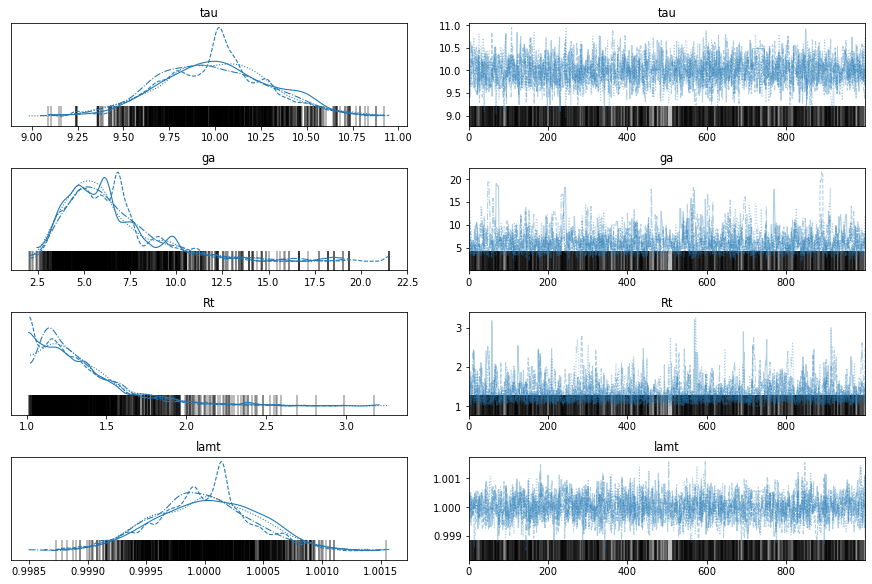

In [29]:
pm.traceplot(trace)
plt.show()

In [33]:
trace

<MultiTrace: 4 chains, 1000 iterations, 8 variables>

In [ ]:
    T = len(dataset['day'])
    tau = pm.Gamma("tau", alpha=1000, beta =100)
    ga = pm.InverseGamma("ga", mu = 7.5, sd = 3.4)
    # Estimate paramter Rt
    for t in range(T-1):
        K[t] = covid_cases['Alabama'].iloc[t]
        if t == 1: R[t] = 0
        if k[t-1] == 0:
            R[t] = pm.HalfNormal( "R[t]", mu = 0 , sigma = tau )
        else:
            R[t] = pm.HalfNormal( "R[t]", mu = R[t-1] , sigma = tau )
        lam[t] = K[t] * exp( ga * (R[t] - 1) )
        y[t] = pm.Possion("y[t]", mu = lam[t], observed = Alabama_y )

In [11]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.84917042),
 'beta': array([0.94096955, 2.86494249]),
 'sigma_log__': array(0.03750304),
 'sigma': array(1.03821515)}